<a href="https://colab.research.google.com/github/skyshine460/music_genre/blob/main/submission_musicgenre_18_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt


# warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
# warnings.simplefilter('ignore', UserWarning)


N_CLASSES = 11

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
df_train = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/test.csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/genre_labels.csv")

In [3]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [4]:
# feature engineering

df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self

    def transform(self, series):
        return series.map(self.counts).fillna(0)

    def fit_transform(self, series):
        return self.fit(series).transform(series)
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan


columns_label_enc = ["region"]
for col in columns_count_enc:
    df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "labelenc_" + col] = np.nan


class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]

    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)

df["log_tempo"] = np.log(df["tempo"])
gfe = GroupFeatureExtractor(
    "region",
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
    ["zscore"]
)
df = pd.concat([df, gfe.fit_transform(df)], axis=1)


class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)

    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self

    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)

        return df_knn


# feature scaling

df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]



df_train, df_test = split_train_test(df)
target = df_train["genre"]

In [5]:
# parameters

# def lgb_metric(preds, data):
#     pred_labels = preds.reshape(N_CLASSES, -1).argmax(axis=0)
#     score = f1_score(data.get_label(), pred_labels, average="macro")
#     return "macro_f1", score, True

learning_rate = 0.01

lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    #"metric": "None",
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": 0,
    "seed": 42,
}

knn_n_neighbors = 6


# parameters - knn feature weights

knn_features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans'
]

dict_feature_weights = {}

for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])

In [6]:
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()

features_numerical = [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'tempo',
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown', 'countenc_region',
    'num_nans',
    'agg_zscore_popularity_grpby_region',
    'agg_zscore_duration_ms_grpby_region',
    'agg_zscore_acousticness_grpby_region',
    'agg_zscore_positiveness_grpby_region',
    'agg_zscore_danceability_grpby_region',
    'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
    'agg_zscore_liveness_grpby_region',
    'agg_zscore_speechiness_grpby_region',
    'agg_zscore_instrumentalness_grpby_region',
    'agg_zscore_log_tempo_grpby_region',
    'knn_score_class00', 'knn_score_class01',
    'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
    'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
    'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
    'max_knn_scores',
    'sub_max_knn_scores_knn_score_class00',
    'sub_max_knn_scores_knn_score_class01',
    'sub_max_knn_scores_knn_score_class02',
    'sub_max_knn_scores_knn_score_class03',
    'sub_max_knn_scores_knn_score_class04',
    'sub_max_knn_scores_knn_score_class05',
    'sub_max_knn_scores_knn_score_class06',
    'sub_max_knn_scores_knn_score_class07',
    'sub_max_knn_scores_knn_score_class08',
    'sub_max_knn_scores_knn_score_class09',
    'sub_max_knn_scores_knn_score_class10',
    'sub_knn_score_class00_knn_score_class08',
    'sub_knn_score_class00_knn_score_class10',
    'sub_knn_score_class01_knn_score_class08',
    'sub_knn_score_class01_knn_score_class10',
    'sub_knn_score_class02_knn_score_class08',
    'sub_knn_score_class02_knn_score_class10',
    'sub_knn_score_class03_knn_score_class08',
    'sub_knn_score_class03_knn_score_class10',
    'sub_knn_score_class04_knn_score_class08',
    'sub_knn_score_class04_knn_score_class10',
    'sub_knn_score_class05_knn_score_class08',
    'sub_knn_score_class05_knn_score_class10',
    'sub_knn_score_class06_knn_score_class08',
    'sub_knn_score_class06_knn_score_class10',
    'sub_knn_score_class07_knn_score_class08',
    'sub_knn_score_class07_knn_score_class10',
    'sub_knn_score_class08_knn_score_class09',
    'sub_knn_score_class08_knn_score_class10',
    'sub_knn_score_class09_knn_score_class10',
    'sum_knn_scores'
]
features_categorical = ["labelenc_region"]
features = features_numerical + features_categorical

------------------------------ fold 0 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Fold 0 F1 score: 0.63458

------------------------------ fold 1 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 1 F1 score: 0.69220

------------------------------ fold 2 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 2 F1 score: 0.63773

------------------------------ fold 3 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 3 F1 score: 0.63971

------------------------------ fold 4 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 4 F1 score: 0.70102

------------------------------ fold 5 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 5 F1 score: 0.62397

------------------------------ fold 6 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 6 F1 score: 0.70752

------------------------------ fold 7 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 7 F1 score: 0.64331

------------------------------ fold 8 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 8 F1 score: 0.69783

------------------------------ fold 9 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 9 F1 score: 0.67594

------------------------------ fold 10 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 10 F1 score: 0.66984

------------------------------ fold 11 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 11 F1 score: 0.69363

------------------------------ fold 12 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 12 F1 score: 0.61049

------------------------------ fold 13 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 13 F1 score: 0.61440

------------------------------ fold 14 ------------------------------


<ipython-input-7-5861b3d695a2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


Fold 14 F1 score: 0.63526


Fold-wise F1 scores:
  Fold 0: 0.63458
  Fold 1: 0.69220
  Fold 2: 0.63773
  Fold 3: 0.63971
  Fold 4: 0.70102
  Fold 5: 0.62397
  Fold 6: 0.70752
  Fold 7: 0.64331
  Fold 8: 0.69783
  Fold 9: 0.67594
  Fold 10: 0.66984
  Fold 11: 0.69363
  Fold 12: 0.61049
  Fold 13: 0.61440
  Fold 14: 0.63526
CV score
  f1:  0.67109

              precision    recall  f1-score   support

           0       0.87      0.62      0.73        32
           1       0.58      0.43      0.49       205
           2       0.70      0.58      0.64       191
           3       0.80      0.78      0.79       362
           4       0.72      0.62      0.67        45
           5       0.61      0.50      0.55       126
           6       0.63      0.38      0.47        50
           7       0.66      0.62      0.64       334
           8       0.72      0.79      0.76      1305
           9       0.86      0.85      0.85        59
          10       0.78      0.81      0.80      1337

 

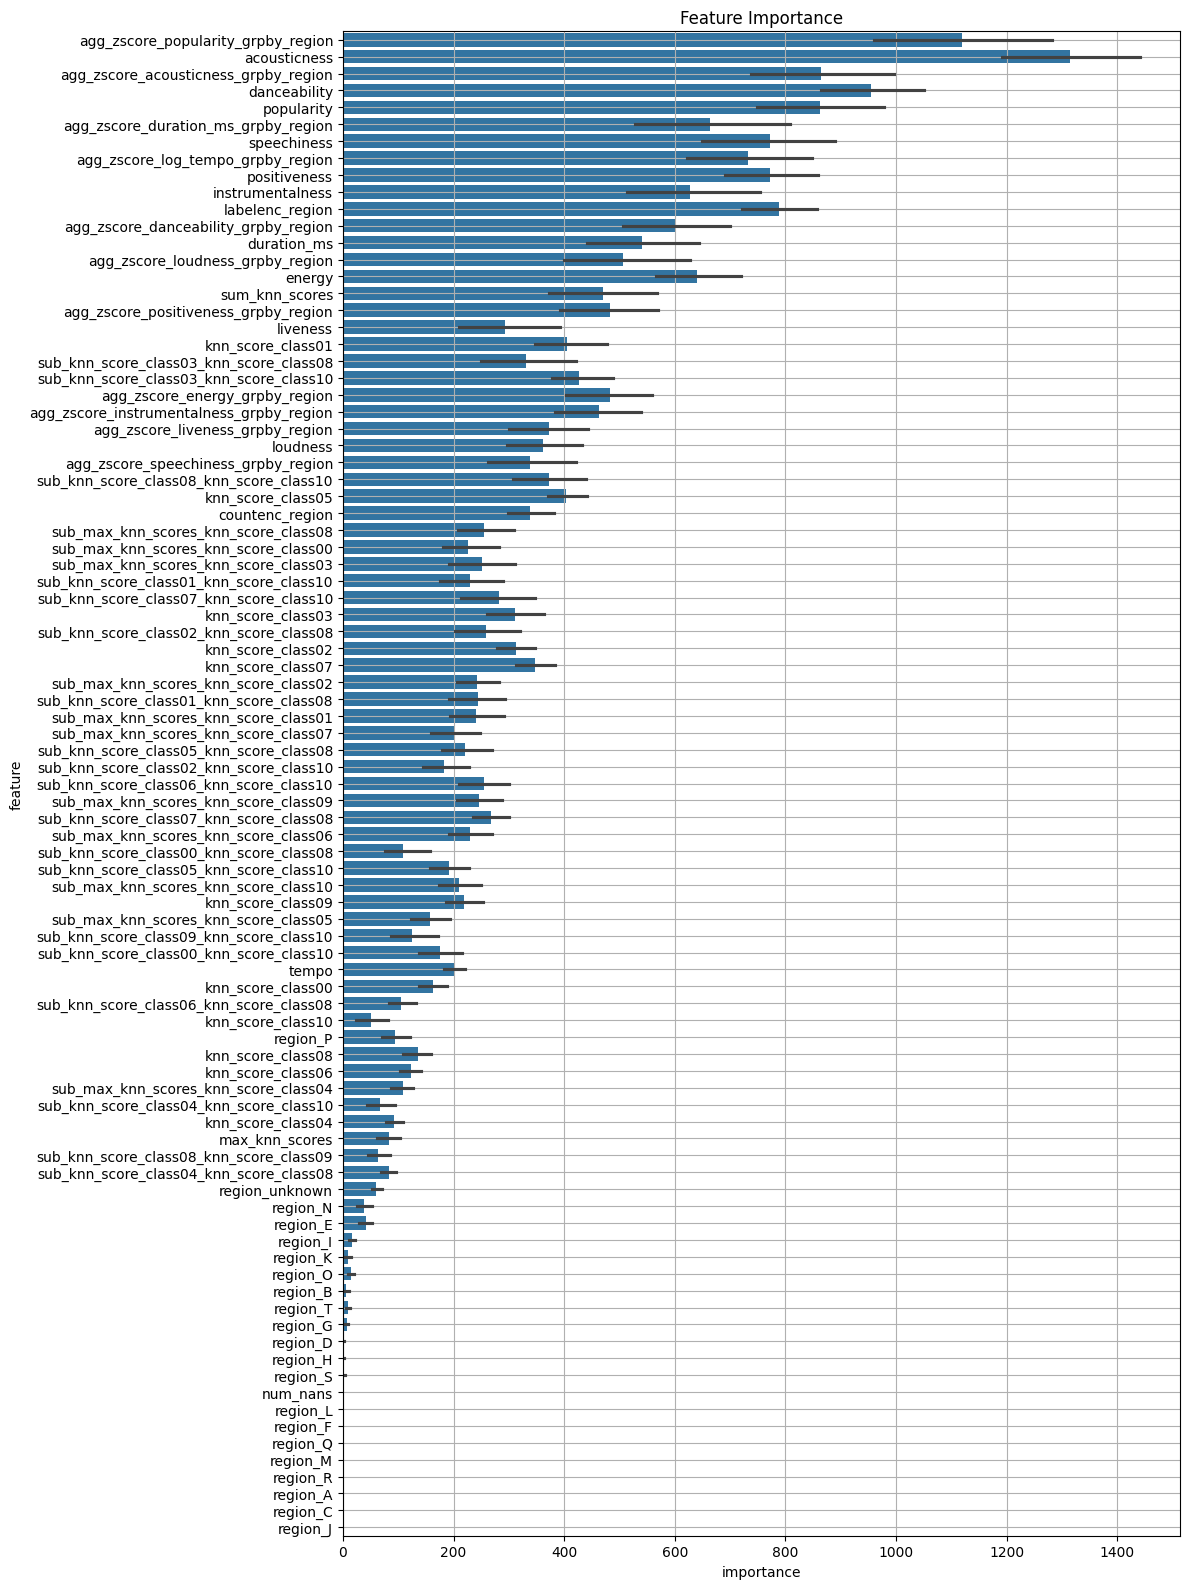

In [7]:
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 各foldごとのF1スコアを格納するリスト
fold_f1_scores = []

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]

    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )

    # モデルパラメータ設定
    lgb_params = {
        "objective": "multiclass",
        "num_class": 11,
        "learning_rate": 0.01,
        "num_leaves": 5,
        "min_data_in_leaf": 40,
        "verbosity": 0,
        "seed": 42
    }

    num_round = 999999999
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_round,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)],
    )

    prediction_round = model.best_iteration + 150 if num_round >= 1e8 else num_round
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    # 各foldのF1スコアを計算
    fold_f1 = f1_score(target_val, oof[indexes_val].argmax(1), average="macro")
    fold_f1_scores.append(fold_f1)
    print(f"Fold {fold_} F1 score: {fold_f1:.5f}")

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

# 各foldのF1スコアを表示
print("\nFold-wise F1 scores:")
for i, f1 in enumerate(fold_f1_scores):
    print(f"  Fold {i}: {f1:.5f}")

# 最終的なF1スコア（全体）
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

# Feature importanceの可視化
plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.grid()
plt.tight_layout()
plt.show()


------------------------------ fold 0 ------------------------------


<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 4: {'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 30, 'seed'

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 5: {'learning_rate': 0.01, 'num_leaves': 3, 'min_data_in_leaf': 30, 'seed': 42}
Best F1 score for fold 5: 0.62694

------------------------------ fold

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 6: {'learning_rate': 0.01, 'num_leaves': 5, 'min_data_in_leaf': 30, 'seed': 42}
Best F1 score for fold 6: 0.72797

------------------------------ fold 7 ------------------------------


<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 7: {'learning_rate': 0.01, 'num_leaves': 5, 'min_data_in_leaf': 40, 'seed':

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 9: {'learning_rate': 0.01, 'num_leaves': 5, 'min_data_in_leaf': 40, 'seed':

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 11: {'learning_rate': 0.01, 'num_leaves': 8, 'min_data_in_leaf': 50, 'seed': 42}
Best F1 score for fold 11: 0.73210

------------------------------ fold 12 ------------------------------


<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 13: {'learning_rate': 0.01, 'num_leaves': 16, 'min_data_in_leaf': 40, 'seed': 42}
Best F1 score for fold 13: 0.63550

------------------------------ f

<ipython-input-10-9ccd8c6c719a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for fold 14: {'learning_rate': 0.01, 'num_leaves': 3, 'min_data_in_leaf': 50, 'seed'

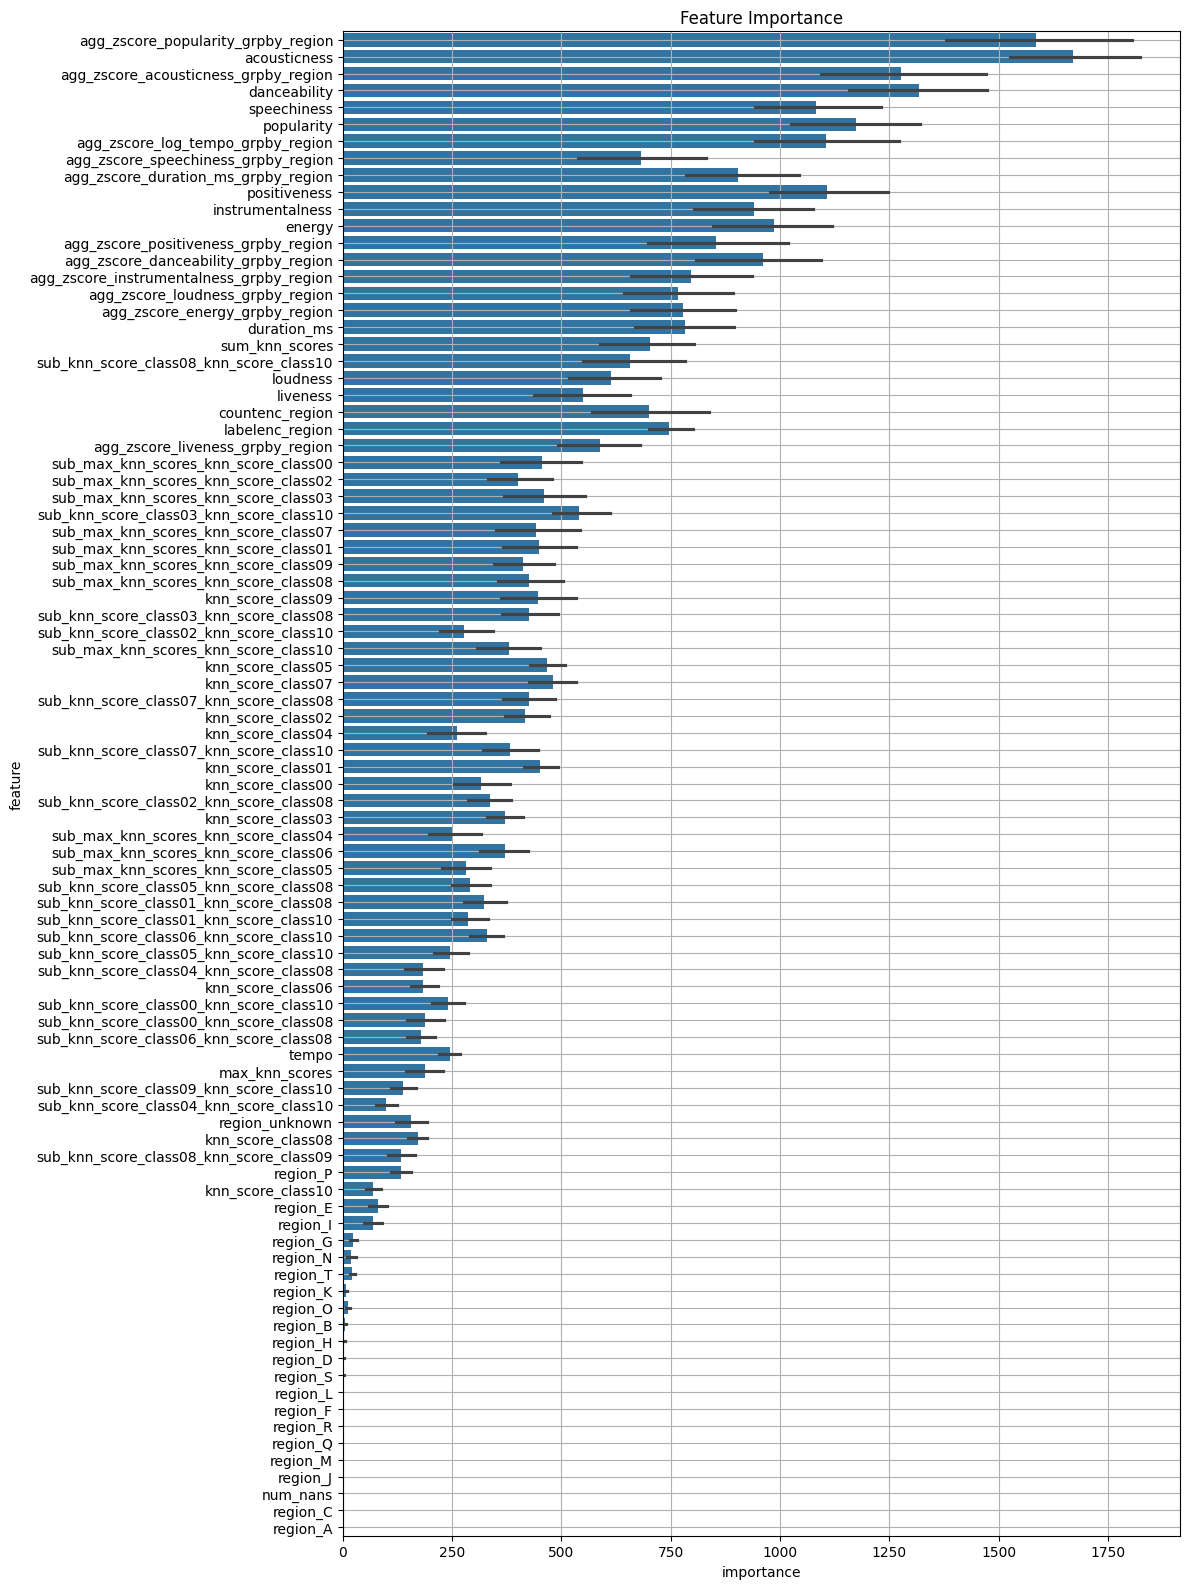

In [10]:
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import lightgbm as lgb

# 各foldごとのF1スコアを格納するリスト
fold_f1_scores = []
param_results = []  # 各パラメータとその対応するF1スコアを格納

# パラメータのグリッドを設定
learning_rates = [0.01]
num_leaves_list = [3, 5, 8, 16]
min_data_in_leaf_list = [30, 40, 50]
seeds = [42]

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]

    best_f1 = -1
    best_params = None

    # パラメータのグリッド探索
    for lr in learning_rates:
        for num_leaves in num_leaves_list:
            for min_data_in_leaf in min_data_in_leaf_list:
                for seed in seeds:
                    lgb_params = {
                        "objective": "multiclass",
                        "num_class": 11,
                        "learning_rate": lr,
                        "num_leaves": num_leaves,
                        "min_data_in_leaf": min_data_in_leaf,
                        "verbosity": 0,
                        "seed": seed
                    }

                    lgb_train = lgb.Dataset(
                        df_trn.loc[:, features],
                        label=target_trn,
                        feature_name=features,
                        categorical_feature=features_categorical
                    )
                    lgb_valid = lgb.Dataset(
                        df_val.loc[:, features],
                        label=target_val,
                        feature_name=features,
                        categorical_feature=features_categorical
                    )

                    num_round = 999999999
                    model = lgb.train(
                        lgb_params,
                        lgb_train,
                        num_round,
                        valid_sets=[lgb_train, lgb_valid],
                        callbacks=[
                            lgb.early_stopping(stopping_rounds=50, verbose=False),
                            lgb.log_evaluation(0)],
                    )

                    prediction_round = model.best_iteration + 150 if num_round >= 1e8 else num_round
                    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

                    # F1スコアを計算
                    fold_f1 = f1_score(target_val, oof[indexes_val].argmax(1), average="macro")
                    fold_f1_scores.append(fold_f1)

                    # パラメータとF1スコアを記録
                    param_results.append({
                        "learning_rate": lr,
                        "num_leaves": num_leaves,
                        "min_data_in_leaf": min_data_in_leaf,
                        "seed": seed,
                        "verbosity": 1,
                        "f1_score": fold_f1
                    })

                    # 最適なパラメータを保存
                    if fold_f1 > best_f1:
                        best_f1 = fold_f1
                        best_params = {
                            "learning_rate": lr,
                            "num_leaves": num_leaves,
                            "min_data_in_leaf": min_data_in_leaf,
                            "seed": seed
                        }

    print(f"Best parameters for fold {fold_}: {best_params}")
    print(f"Best F1 score for fold {fold_}: {best_f1:.5f}")

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

# 各foldのF1スコアを表示
print("\nFold-wise F1 scores:")
for i, f1 in enumerate(fold_f1_scores):
    print(f"  Fold {i}: {f1:.5f}")

# 最終的なF1スコア（全体）
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

# パラメータごとの結果を表示
df_param_results = pd.DataFrame(param_results)
print("\nBest Parameters and their F1 scores across folds:")
print(df_param_results.sort_values(by="f1_score", ascending=False))

# Feature importanceの可視化
plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()

In [ ]:
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submission_musicgenre_18.csv", header=None, index=False)